In [115]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

In [116]:
# read in the data
data_train = pd.read_csv("data/train.csv")
data_test = pd.read_csv("data/test.csv")

In [117]:
# confirm shape of the training data
data_train.shape

(1460, 81)

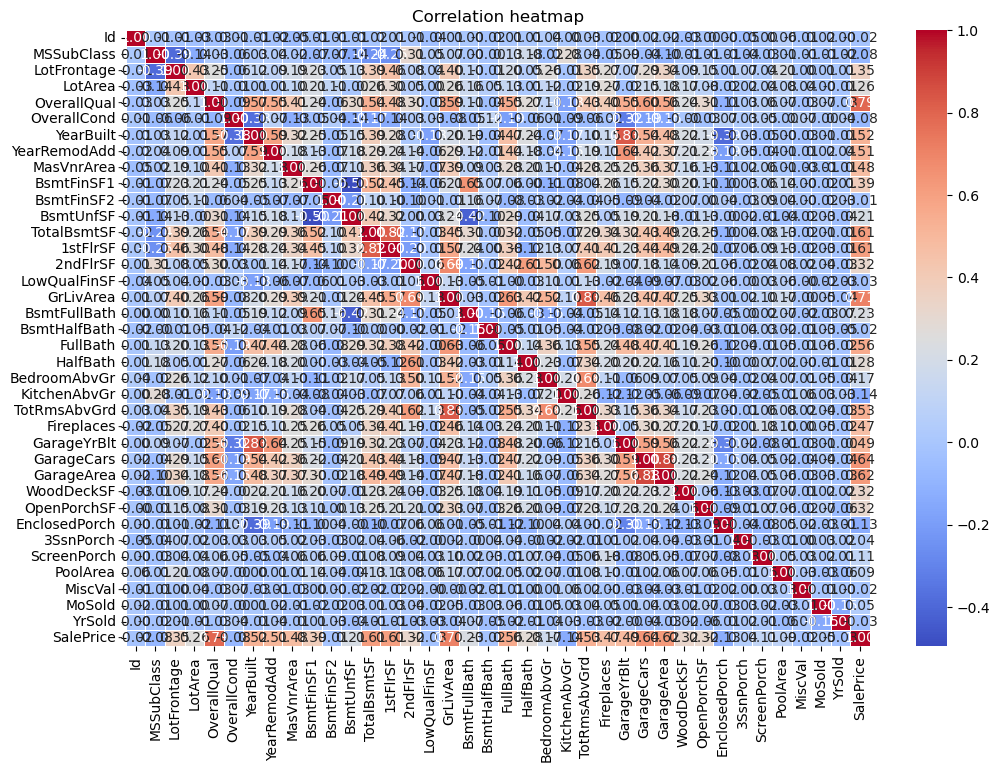

In [118]:
# Plot correlation heatmap

correlation_matrix = data_train.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation heatmap")
plt.show()

In [119]:
# Show highly correlated pairs of features

# Set correlation threshold
threshold = 0.7

# Create a mask for absolute correlations above threshold
high_corr = correlation_matrix.abs() > threshold

# Extract correlated pairs (excluding self-correlations)
correlated_pairs = []

for col in correlation_matrix.columns:
    for idx in correlation_matrix.index:
        if col != idx and high_corr.loc[idx, col]:
            correlated_pairs.append((idx, col, correlation_matrix.loc[idx, col]))

# Convert to DataFrame for easier viewing
corr_df = pd.DataFrame(correlated_pairs, columns=["Feature 1", "Feature 2", "Correlation"])

# Drop duplicate pairs (A,B) == (B,A)
corr_df = corr_df.sort_values(by="Correlation", ascending=False).drop_duplicates(subset=["Correlation"])

print("Highly Correlated Feature Pairs")
print(corr_df)

Highly Correlated Feature Pairs
      Feature 1    Feature 2  Correlation
8    GarageArea   GarageCars     0.882475
1   GarageYrBlt    YearBuilt     0.825667
4  TotRmsAbvGrd    GrLivArea     0.825489
2      1stFlrSF  TotalBsmtSF     0.819530
0     SalePrice  OverallQual     0.790982
5     SalePrice    GrLivArea     0.708624


We created a correlation matrix of all of the numeric (non-categorial)
variables. There are 6 pairs of features with an absolute value
correlation higher than 0.7.

From the above table, we would want to choose only Feature 1 or Feature
2 to avoid high multicollinearity in our model.

In [120]:
# Check outliers
z_scores = np.abs(stats.zscore(data_train.select_dtypes(include='number')))
print((z_scores > 3).sum())

639


In [121]:
# Compute absolute z-scores
numeric_train = data_train.select_dtypes(include='number')

z_scores = np.abs(stats.zscore(numeric_train, nan_policy='omit'))

# Convert to DataFrame
z_df = pd.DataFrame(z_scores, columns=numeric_train.columns)

# Threshold
threshold = 3

# Boolean mask for outliers
outlier_mask = (z_df > threshold)

# Count outliers per column
outlier_counts = outlier_mask.sum().sort_values(ascending=False)

print("Outlier Counts per Column")
print(outlier_counts[outlier_counts > 0])

# Print column names that actually have outliers
outlier_columns = outlier_counts[outlier_counts > 0].index.tolist()
print("Columns with outliers:")
print(outlier_columns)

Outlier Counts per Column
BsmtHalfBath     82
KitchenAbvGr     68
ScreenPorch      55
EnclosedPorch    51
BsmtFinSF2       50
MasVnrArea       32
MSSubClass       30
OverallCond      28
OpenPorchSF      27
3SsnPorch        23
SalePrice        22
WoodDeckSF       22
LowQualFinSF     20
GrLivArea        16
BsmtFullBath     16
BedroomAbvGr     14
LotArea          13
HalfBath         12
TotRmsAbvGrd     12
1stFlrSF         12
LotFrontage      12
BsmtUnfSF        11
TotalBsmtSF      10
MiscVal           8
PoolArea          7
GarageArea        7
YearBuilt         6
BsmtFinSF1        6
Fireplaces        5
2ndFlrSF          4
OverallQual       2
GarageYrBlt       1
dtype: int64
Columns with outliers:
['BsmtHalfBath', 'KitchenAbvGr', 'ScreenPorch', 'EnclosedPorch', 'BsmtFinSF2', 'MasVnrArea', 'MSSubClass', 'OverallCond', 'OpenPorchSF', '3SsnPorch', 'SalePrice', 'WoodDeckSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BedroomAbvGr', 'LotArea', 'HalfBath', 'TotRmsAbvGrd', '1stFlrSF', 'LotFront

In [122]:
# Check total and percentage of missing values
missing_counts = data_train.isnull().sum()
missing_percent = (data_train.isnull().sum() / len(data_train)) * 100

missing_summary = pd.DataFrame({'Missing Count': missing_counts, 'Missing %': missing_percent})
print(missing_summary[missing_summary['Missing Count'] > 0])

              Missing Count  Missing %
LotFrontage             259  17.739726
Alley                  1369  93.767123
MasVnrType              872  59.726027
MasVnrArea                8   0.547945
BsmtQual                 37   2.534247
BsmtCond                 37   2.534247
BsmtExposure             38   2.602740
BsmtFinType1             37   2.534247
BsmtFinType2             38   2.602740
Electrical                1   0.068493
FireplaceQu             690  47.260274
GarageType               81   5.547945
GarageYrBlt              81   5.547945
GarageFinish             81   5.547945
GarageQual               81   5.547945
GarageCond               81   5.547945
PoolQC                 1453  99.520548
Fence                  1179  80.753425
MiscFeature            1406  96.301370


In [123]:
# Drop columns with >= 60% missing values
data_train = data_train.drop(columns=['Alley', 'PoolQC', 'Fence', 'MiscFeature'])
data_test = data_test.drop(columns=['Alley', 'PoolQC', 'Fence', 'MiscFeature'])

In [124]:
# Fill numeric columns with median
for col in data_train.select_dtypes(include='number').columns:
    data_train[col] = data_train[col].fillna(data_train[col].median())

for col in data_test.select_dtypes(include='number').columns:
    data_test[col] = data_test[col].fillna(data_test[col].median())

In [125]:
# Fill categorical columns with mode
for col in data_train.select_dtypes(include='object').columns:
    if data_train[col].mode().size > 0:
        data_train[col] = data_train[col].fillna(data_train[col].mode()[0])

for col in data_test.select_dtypes(include='object').columns:
    if data_test[col].mode().size > 0:
        data_test[col] = data_test[col].fillna(data_test[col].mode()[0])

In [126]:
# Verify that all missing values were handled:
print(data_train.isnull().sum().sum(), "missing values remain.")

0 missing values remain.


In [128]:
# Split training set into training and validation so that we can measure
# MSE
X = data_train.drop('SalePrice', axis=1)
y = data_train['SalePrice']

X_train, X_validate, y_train, y_validate = train_test_split(X, y, train_size=0.7, random_state=123)